# Perceptron Lab





In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
from scipy.io import arff
from astropy.table import QTable, Table, Column
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math


## 1. (40%) Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
- Shuffle the data each epoch.
- A way to create a random train/test split. Write your own. In the future you can use the scikit-learn version if you want.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a stopping criteria: when your model has trained for a number of epochs with no significant improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
- Use your perceptron to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your perceptron on the Evaluation data with the same parameters, and include your final weights in your report PDF.

In [3]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True, deterministic=False):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.deterministic=deterministic

    def fit(self, X, y, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.weights = self.initialize_weights(X.shape[1] + 1) if not initial_weights else np.array(initial_weights)
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        if self.deterministic:
            self.epochs = 10
            for i in range(self.epochs):
                X,y = self._perform_epoch(X,y)
        else:
            self.epochs = 0
            sameAccuracyEpochs = 0
            bestAccuracy = 0
            while(sameAccuracyEpochs < 5):
                X,y = self._perform_epoch(X,y)
                self.epochs += 1
                accuracy = self.score(X,y)
                if (accuracy < bestAccuracy) or (np.absolute(bestAccuracy - accuracy) < .02):
                    sameAccuracyEpochs += 1
                else:
                    sameAccuracyEpochs = 0
                if accuracy > bestAccuracy:
                    bestAccuracy = accuracy
            model.finalAccuracy = bestAccuracy
        return self

    def _perform_epoch(self, X, y):
        for j in range(X.shape[0]):
            net = np.dot(X[j], self.weights)
            output = np.where(net>0,1,0)
            self.weights = np.add(self.weights, self.lr*(y[j]-output)*X[j])
        if self.shuffle:
            X,y =self._shuffle_data(X,y)
        return X,y
    
    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        prediction = np.array([])
        for j in range(X.shape[0]):
                net = np.dot(X[j], self.weights)
                output = np.where(net>0,1,0)
                prediction = np.append(prediction, output)
        return prediction, prediction.shape[0]

    def initialize_weights(self, size):
        # Initialize weights for perceptron. Don't forget the bias!
        return np.random.rand(size)*0.1-0.05

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        prediction, length = self.predict(X)
        correct = 0
        for i in range(length):
            if prediction[i] == y[i]:
                correct += 1
        
        return correct/length

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        xy = np.column_stack((X,y))
        size = xy.shape[0]
        for i in range(size):
            swapIndex = np.random.randint(0,size)
            xy[i], xy[swapIndex] = xy[swapIndex], xy[i].copy()
        return xy[:,:-1], xy[:,-1]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights
    
def random_split(xy):
    # shuffle data
    size = xy.shape[0]
    for i in range(size):
        swapIndex = np.random.randint(0,size)
        xy[i], xy[swapIndex] = xy[swapIndex], xy[i].copy()
    data_splitter = int(math.ceil(size / 10)) * 7
    print(data_splitter)
    training_data = xy[:data_splitter]
    test_data = xy[data_splitter:]
    return training_data, test_data
    

## 1.1 Debug 

Debug your model by running it on the [debug dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)

Parameters:

Learning Rate = 0.1\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Initial Weights = All zeros

---

Expected Results

Accuray = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [4]:
# Load debug data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output debug-dataset.arff
data = arff.loadarff('debug-dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.reshape([int(s.decode()) for s in np_data[:,-1]], (-1, 1))

xy = np.column_stack((X,y))
a,b = random_split(xy)

weights = [0] * (X.shape[1] + 1)
print(weights)
# Train on debug data
model = PerceptronClassifier(.1, False, True)
model.fit(X,y, weights)
# Check weights
X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
print("Accuracy = ", model.score(X,y))
print("Final Weights = ", model.get_weights())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   1683      0 --:--:-- --:--:-- --:--:--  1683
7
[0, 0, 0]
Accuracy =  0.875
Final Weights =  [-0.23000000000000004 0.1799999999999999 -0.1]


## 1.2 Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [4]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output bank-dataset.arff
data = arff.loadarff('bank-dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.reshape([int(s.decode()) for s in np_data[:,-1]], (-1, 1))
weights = [0] * (X.shape[1] + 1)
# Train on evaluation data
model = PerceptronClassifier(.1, False, True)
model.fit(X,y, weights)
# Print weights
print("Final Weights = ", model.get_weights())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   166k      0 --:--:-- --:--:-- --:--:--  167k
Final Weights =  [-3.80657242 -2.8408210000000014 -3.0719334000000034 -1.4003906000000004
 4.899999999999999]


## 2. (10%) Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.
- Graph each dataset

![Linearly Separable Data](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/linearly_separable.png)

![Not Linearly Separable](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/not_linearly_separable.png)

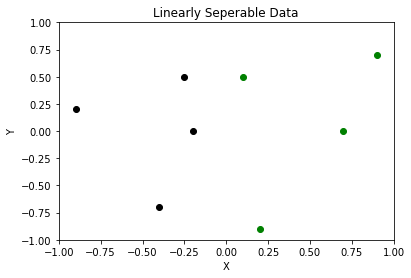

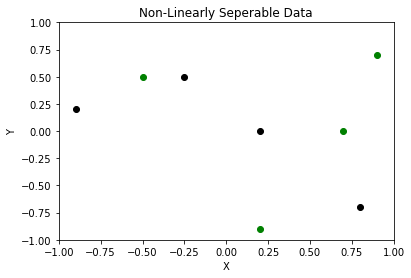

In [5]:
# Create 2 datasets
plt.title('Linearly Seperable Data')
plt.xlabel('X')
plt.ylabel('Y')
seperable = np.array([[-.4,-.7,1],
               [-.2,0,1],
               [-.25,.5,1],
               [-.9,.2,1],
               [.2,-.9,0],
               [.7,0,0],
               [.1,.5,0],
               [.9,.7,0]])

plt.scatter(seperable[0:4,0],seperable[0:4,1], color="black")
plt.scatter(seperable[4:8,0],seperable[4:8,1], color="green")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()
plt.clf()

plt.title('Non-Linearly Seperable Data')
plt.xlabel('X')
plt.ylabel('Y')
nonseperable = np.array([[.8,-.7,1],
               [.2,0,1],
               [-.25,.5,1],
               [-.9,.2,1],
               [.2,-.9,0],
               [.7,0,0],
               [-.5,.5,0],
               [.9,.7,0]])

plt.scatter(nonseperable[0:4,0],nonseperable[0:4,1], color="black")
plt.scatter(nonseperable[4:8,0],nonseperable[4:8,1], color="green")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

## 3. (10%) Train on both sets with your perceptron code.

- Use a couple different learning rates.


In [6]:
X = seperable[:,:-1]
y = np.reshape(seperable[:,-1], (-1,1))

# Train on evaluation data
sep_model = PerceptronClassifier()
sep_model.fit(X,y)

X = nonseperable[:,:-1]
y = np.reshape(nonseperable[:,-1], (-1,1))

nonsep_model = PerceptronClassifier()
nonsep_model.fit(X,y)

PerceptronClassifier()

Discuss the effect of learning rate, including how many epochs are completed before stopping. (For these cases, learning rate should have minimal effect, unlike with the Backpropagation lab.)


The learning rate didn't have much of an effect. It seemed like the shuffling and randomized weights made it too highly variable. I got stopping rates between 6-11 inclusive typically.



## 4. (10%) Graph the instances and decision line for the two cases above (with LR=.1)
 
 - For all graphs always label the axes!

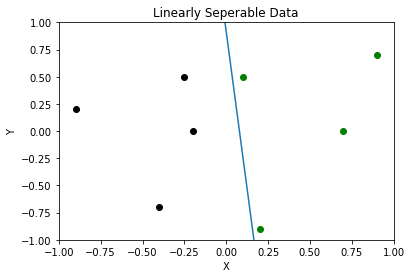

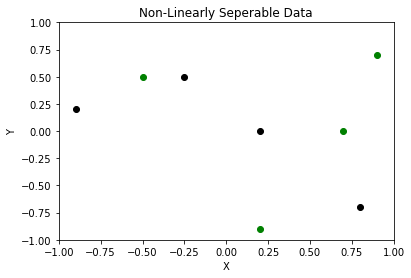

<Figure size 432x288 with 0 Axes>

In [15]:
# Graph decision line
plt.title('Linearly Seperable Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(seperable[0:4,0],seperable[0:4,1], color="black")
plt.scatter(seperable[4:8,0],seperable[4:8,1], color="green")
sep_weights = sep_model.get_weights()
x = np.linspace(-1,1,100)
sep_line = (-(sep_weights[2] / sep_weights[1]) / (sep_weights[2] / sep_weights[0]))*x + (-sep_weights[2] / sep_weights[1])
plt.plot(x,sep_line)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()
plt.clf()

plt.title('Non-Linearly Seperable Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(nonseperable[0:4,0],nonseperable[0:4,1], color="black")
plt.scatter(nonseperable[4:8,0],nonseperable[4:8,1], color="green")
nonsep_weights = nonsep_model.get_weights()
x = np.linspace(-1,1,100)
sep_line = (-(nonsep_weights[2] / nonsep_weights[1]) / (nonsep_weights[2] / nonsep_weights[0]))*x + (-nonsep_weights[2] / nonsep_weights[1])
plt.plot(x,sep_line)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()
plt.clf()



## 5. (20%) Use your perceptron code to learn this version of the [voting data set](https://raw.githubusercontent.com/rmorain/CS472-1/master/datasets/perceptron/voting-dataset.arff).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 5.1 Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the average of these values for the 5 trials in the table.  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| Average each value by trial| | | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [16]:
def dem_repub(arr):
    print(arr.shape[0])
    for i in range(arr.shape[0]):
        if arr[i] == 'democrat':
            arr[i] = 0
        else:
            arr[i] = 1
    return arr

def yes_no(arr):
    print(arr.shape[0])
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i,j] == 'n':
                arr[i,j] = 0
            else:
                arr[i,j] = 1
    return arr


# Create table any way you like

!curl https://raw.githubusercontent.com/rmorain/CS472-1/master/datasets/perceptron/voting-dataset.arff --output voting-dataset.arff
data = arff.loadarff('voting-dataset.arff')
df = pd.DataFrame(data[0])
df = df.apply(lambda x: x.str.decode('utf-8'))
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.reshape(np_data[:,-1], (-1, 1))
y = dem_repub(y)
X = yes_no(X)
training, test = random_split(np.column_stack((X,y)))

model = PerceptronClassifier(.1, True, False)
model.fit(training[:,0:-1],np.reshape(training[:,-1], (-1, 1)))
testX = test[:,0:-1]
testX = np.concatenate((testX,np.ones((testX.shape[0],1))),axis=1)

train_ac = np.array([.93,.91,.91,.95,.92])
test_ac = np.array([.97,.98,.97,.96,.98])
epochs = np.array([6,7,6,7,7])

table = Table([range(1, 6), train_ac, test_ac, epochs], names=["TestNum", "Training Accuracy", "Test Accuracy", "Number of Epochs"])

print(table)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43825  100 43825    0     0   279k      0 --:--:-- --:--:-- --:--:--  279k
461
461
329
TestNum Training Accuracy Test Accuracy Number of Epochs
------- ----------------- ------------- ----------------
      1              0.93          0.97                6
      2              0.91          0.98                7
      3              0.91          0.97                6
      4              0.95          0.96                7
      5              0.92          0.98                7


### 5.2 By looking at the weights, explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


The most critical feature for the voting task are physcian fee freeze, el salvador aid, aid-to-nicaraguan-contras, and immigration. Least critical are water-project-cost-sharing, duty-free-exports, and synfuels-corporation-cutback.

### 5.3 Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs).


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

In [9]:
# Graph here
    
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()
    


## 6. (10%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above and also one other data set of your choice.

- Report and compare your results.
- Try out some of the hyper-parameters that scikit-learn makes available on your own perceptron.

In [10]:
# Load sklearn perceptron

# Train on voting dataset

*Report your comparison*

## 7. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) or some other task with more than two possible output values. 

Note that the [iris data](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement either of the two most common ways to deal with this. For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.